In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
import numpy as np
import cv2 
import os


def dataset_setup(data_dir='', n_ims=2975, offset_bias=0, img_dim=256):
    """
    Method to import the training data from CityScape and divide into image-label pairs

    Inputs
    --
    data_dir: string
        Location for the data that is being imported
    n_ims: int
        Number of images contained in the folder chosen
    offset_bias: int
        Optionally, skip some images by starting at a position further than 0
    img_dim: int
        Expected image dimension (assuming square images)

    Outputs
    --
    X: list
        Images
    y: list
        Image labels per pixel
    """

    flist = os.listdir(data_dir)
    img0 = cv2.imread(data_dir+flist[0])

    y_dim,x_dim,_ = np.shape(img0)
    X = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    y = np.zeros((n_ims,y_dim,int(x_dim/2),3))
    
    k = 0
    for f in flist[offset_bias:offset_bias+n_ims]:
        X[k] = cv2.imread(data_dir+f)[:,:img_dim]/img_dim
        y[k] = cv2.imread(data_dir+f)[:,img_dim:]/img_dim
        k = k+1

    return X, y

In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Directories containing the train and val data
train_files = "./ECE228_project/data/train/"
test_files = "./ECE228_project/data/val/"

# Setup image-label pairs
x, y = dataset_setup(data_dir=train_files, n_ims=2975, offset_bias=0, img_dim=256)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, random_state=42)
x_test, y_test = dataset_setup(data_dir=test_files, n_ims=500, offset_bias=0, img_dim=256)

In [3]:
from tensorflow.keras.layers import MaxPooling2D, Dropout, Conv2DTranspose, Conv2D, concatenate
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.backend import binary_crossentropy, square
from tensorflow.keras.backend import sum as ksum
from tensorflow.keras import Model, Input
import tensorflow as tf


def reconstruction_loss(y_true, y_pred):
    """
    Using binary crossentropy from Keras for reconstruction loss
    """

    return ksum(binary_crossentropy(y_true, y_pred), axis=-1)


def conv2d_block(input_tensor, n_filters=16, filter_size=3, activation='relu', pad='same', batch_norm=True):
    """
    Custom block method to perform consecutive convolutions with optional batch normalization

    Inputs
    --
    input_tensor: tensor
        Input image tensor data structure defined within Keras
    n_filters: int
        Depth for the convolution layer outputs
    filter_size: int
        Dimensions of the filter convolved with the tensor inputs
    activation: string
        Activation function for the intermediate layers between convolutions
    pad: string
        Determination of if input shape is maintained in convolution
    batch_norm: bool
        Flag if batch normalization is used

    Outputs
    --
    x: tensor
        Twice convolved input with optional batch normalization and activation non-linearities
    """
    
    x = Conv2D(filters=n_filters, kernel_size=(filter_size, filter_size),
               kernel_initializer='he_normal', padding=pad)(input_tensor)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation(activation)(x)

    x = Conv2D(filters=n_filters, kernel_size=(filter_size, filter_size),
               kernel_initializer='he_normal', padding=pad)(x)
    if batch_norm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x


def UNET(input_shape=(256,256,3), conv_block=conv2d_block, n_filters=32, dropout=0.5, padding='same', batch_norm=True):
    """
    UNET architecture as originally outlined in https://arxiv.org/pdf/1505.04597.pdf with modifications 
    to fit different input dimensions. 

    Inputs
    --
    input_shape: tuple(int)
        Tuple in 3D corresponding to the dimensions of the input images
    conv_block: func
        Custom block method to perform consecutive convolutions with optional batch normalization
    n_filters: int
        Number of filters corresponding to depth of input for next layer
    dropout: float
        Dropout percentage hyperparameter to tune overfitting
    padding: string
        Descriptor determining if padding maintain size during convolutions
    batch_norm: bool
        Determines if batch normalization is used

    Outputs
    --
    model: Model
        Returns model architecture without compile
    """

    tensor = Input(shape=input_shape)

    print('Contracting Path')
    c1 = conv_block(tensor, n_filters * 1, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv_block(p1, n_filters * 2, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv_block(p2, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv_block(p3, n_filters * 8,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv_block(p4, n_filters * 16, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    print('Expanding Path')
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding=padding)(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv_block(u6, n_filters * 8,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding=padding)(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv_block(u7, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv_block(u8, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv_block(u9, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[tensor], outputs=[outputs])

    # Return model architecture
    return model


def UNET_plusplus(input_shape=(256,256,3), conv_block=conv2d_block, n_filters=32, dropout=0.5, padding='same', batch_norm=True):
    """
    UNET++ architecture as originally outlined in https://arxiv.org/pdf/1807.10165.pdf with modifications 
    to fit different input dimensions. 

    Inputs
    --
    input_shape: tuple(int)
        Tuple in 3D corresponding to the dimensions of the input images
    conv_block: func
        Custom block method to perform consecutive convolutions with optional batch normalization
    n_filters: int
        Number of filters corresponding to depth of input for next layer
    dropout: float
        Dropout percentage hyperparameter to tune overfitting
    padding: string
        Descriptor determining if padding maintain size during convolutions
    batch_norm: bool
        Determines if batch normalization is used

    Outputs
    --
    model: Model
        Returns model architecture without compile
    """

    tensor = Input(shape=input_shape)

    print('Backbone')
    
    c00 = conv_block(tensor, n_filters * 1, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p00 = MaxPooling2D((2, 2))(c00)
    p00 = Dropout(dropout)(p00)
    
    c10 = conv_block(p00, n_filters * 2, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p10 = MaxPooling2D((2, 2))(c10)
    p10 = Dropout(dropout)(p10)

    c20 = conv_block(p10, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p20 = MaxPooling2D((2, 2))(c20)
    p20 = Dropout(dropout)(p20)

    c30 = conv_block(p20, n_filters * 8,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    p30 = MaxPooling2D((2, 2))(c30)
    p30 = Dropout(dropout)(p30)

    c40 = conv_block(p30, n_filters * 16, filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    
    print('First Up Path')
    
    u01 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c10)
    u01 = concatenate([u01, c00])
    u01 = Dropout(dropout)(u01)
    c01 = conv_block(u01, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)
    
    print('Second Up Path')

    u11 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c20)
    u11 = concatenate([u11, c10])
    u11 = Dropout(dropout)(u11)
    c11 = conv_block(u11, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u02 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c11)
    u02 = concatenate([u02, c01, c00])
    u02 = Dropout(dropout)(u02)
    c02 = conv_block(u02, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm) 
    
    print('Third Up Path')

    u21 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding=padding)(c30)
    u21 = concatenate([u21, c20])
    u21 = Dropout(dropout)(u21)
    c21 = conv_block(u21, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)   

    u12 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c21)
    u12 = concatenate([u12, c11, c10])
    u12 = Dropout(dropout)(u12)
    c12 = conv_block(u12, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u03 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c12)
    u03 = concatenate([u03, c02, c01, c00])
    u03 = Dropout(dropout)(u03)
    c03 = conv_block(u03, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)    

    print('Final Up Path')

    u31 = Conv2DTranspose(n_filters * 8, (3, 3), strides=(2, 2), padding=padding)(c40)
    u31 = concatenate([u31, c30])
    u31 = Dropout(dropout)(u31)
    c31 = conv_block(u31, n_filters * 8,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm) 

    u22 = Conv2DTranspose(n_filters * 4, (3, 3), strides=(2, 2), padding=padding)(c31)
    u22 = concatenate([u22, c21, c20])
    u22 = Dropout(dropout)(u22)
    c22 = conv_block(u22, n_filters * 4,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u13 = Conv2DTranspose(n_filters * 2, (3, 3), strides=(2, 2), padding=padding)(c22)
    u13 = concatenate([u13, c12, c11, c10])
    u13 = Dropout(dropout)(u13)
    c13 = conv_block(u13, n_filters * 2,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)

    u04 = Conv2DTranspose(n_filters * 1, (3, 3), strides=(2, 2), padding=padding)(c13)
    u04 = concatenate([u04, c03, c02, c01, c00])
    u04 = Dropout(dropout)(u04)
    c04 = conv_block(u04, n_filters * 1,  filter_size=3, activation='relu', pad=padding, batch_norm=batch_norm)  

    #Outputs
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c04)
    model = Model(inputs=[tensor], outputs=[outputs])

    # Return model architecture
    return model

In [4]:
# Initialize UNET
model = UNET_plusplus(input_shape=(256,256,3), conv_block=conv2d_block, n_filters=8, dropout=0.5, padding='same', batch_norm=True)
print(model.summary())

Backbone
First Up Path
Second Up Path
Third Up Path
Final Up Path
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 8)  0           batch_normalization[0][0]        
____________________________

In [5]:
# Compile model with specified optimizer and loss
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss='mse', metrics = metrics)

In [6]:
datagen1 = tf.keras.preprocessing.image.ImageDataGenerator()

datagen1.fit(x_train)

datagen2 = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    horizontal_flip=True
)

datagen2.fit(x_train)

# Track model history as it trains
h_11 = model.fit(datagen1.flow(x_train, y_train, batch_size=32), \
         steps_per_epoch=len(x_train) // 32, epochs=10, \
              validation_data=datagen1.flow(x_val, y_val, batch_size=32))
h_12 = model.fit(datagen2.flow(x_train, y_train, batch_size=32), \
         steps_per_epoch=len(x_train) // 32, epochs=5, \
              validation_data=datagen2.flow(x_val, y_val, batch_size=32))

# Save the weights
model.save_weights('./checkpoints/UNET++')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 83 steps, validate for 10 steps
Epoch 1/10
83/83 [==============================] - 40s 481ms/step - loss: 0.0399 - accuracy: 0.4225 - val_loss: 0.3345 - val_accuracy: 0.3696
Epoch 2/10
83/83 [==============================] - 26s 309ms/step - loss: 0.0262 - accuracy: 0.6078 - val_loss: 0.0629 - val_accuracy: 0.4163
Epoch 3/10
83/83 [==============================] - 25s 303ms/step - loss: 0.0229 - accuracy: 0.6062 - val_loss: 0.0412 - val_accuracy: 0.5231
Epoch 4/10
83/83 [==============================] - 26s 310ms/step - loss: 0.0209 - accuracy: 0.6067 - val_loss: 0.0314 - val_accuracy: 0.5633
Epoch 5/10
83/83 [==============================] - 25s 304ms/step - loss: 0.0199 - accuracy: 0.6185 - val_loss: 0.0276 - val_accuracy: 0.3961
Epoch 6/10
83/83 [==============================] - 25s 300ms/step - loss: 0.0193 - accuracy: 0.5944 - val_loss: 0.0223 - val_accuracy: 0.4178
Epoch 7/10
83/83 [==============================] 

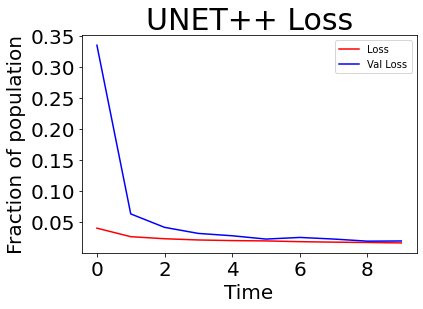

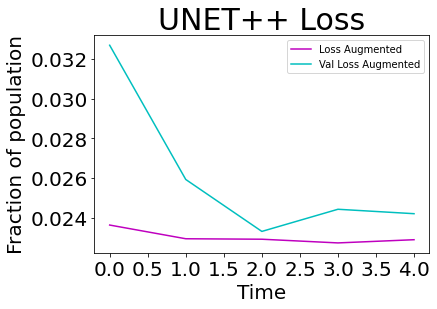

In [11]:
# Print results for training MSE and validation MSE
plt.plot(h_11.history['loss'], 'r', label='Loss')
plt.plot(h_11.history['val_loss'], 'b', label='Val Loss')
plt.title('UNET++ Loss', fontsize=30)
plt.xlabel("Time", fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Fraction of population", fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best')
plt.show()
plt.plot(h_12.history['loss'], 'm', label='Loss Augmented')
plt.plot(h_12.history['val_loss'], 'c', label='Val Loss Augmented')
plt.title('UNET++ Loss', fontsize=30)
plt.xlabel("Time", fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Fraction of population", fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best')
plt.show()

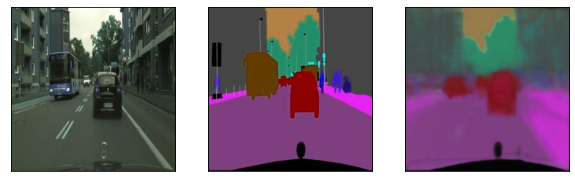

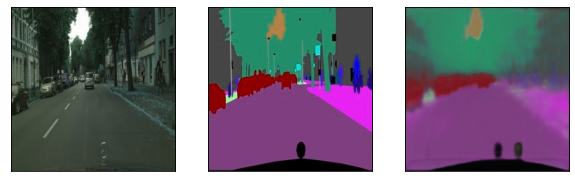

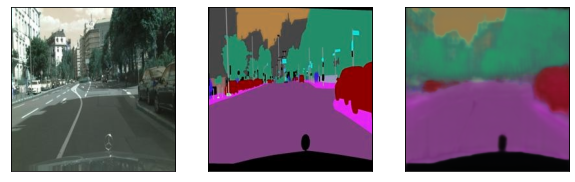

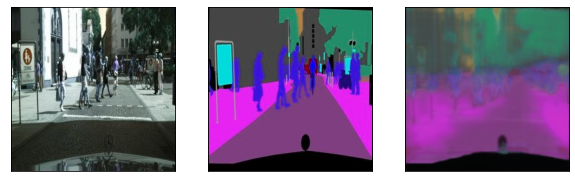

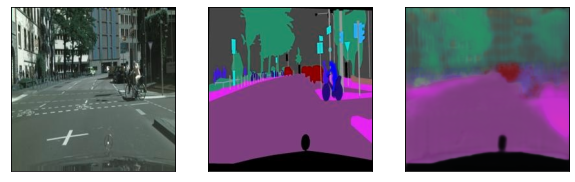

In [8]:
#show the result
pp = model.predict(x_test[:5,:,:,:], batch_size=1)

ni = 5
for k in range(ni):
    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_test[k])
    figure = plt.gca()
    x_axis = figure.axes.get_xaxis()
    x_axis.set_visible(False)
    y_axis = figure.axes.get_yaxis()
    y_axis.set_visible(False)
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_test[k])
    figure = plt.gca()
    x_axis = figure.axes.get_xaxis()
    x_axis.set_visible(False)
    y_axis = figure.axes.get_yaxis()
    y_axis.set_visible(False)
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pp[k])
    figure = plt.gca()
    x_axis = figure.axes.get_xaxis()
    x_axis.set_visible(False)
    y_axis = figure.axes.get_yaxis()
    y_axis.set_visible(False)

In [9]:
intersection = np.logical_and(y_test[1,:,:,:], pp)
union = np.logical_or(y_test[1,:,:,:], pp)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

0.9607899983723959


In [10]:
diff = y_test[1] - pp[1] 
m_norm = np.sum(abs(diff))  
print(m_norm)
print(m_norm/(256*256))

11151.228615228087
0.17015424522747935


In [4]:
# Initialize UNET
model2 = UNET(input_shape=(256,256,3), conv_block=conv2d_block, n_filters=8, dropout=0.5, padding='same', batch_norm=True)
print(model2.summary())

Contracting Path
Expanding Path
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 8)  0           batch_normalization[0][0]        
______________________________________________________________

In [5]:
# Compile model with specified optimizer and loss
optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.01)
metrics2 = ['accuracy']
model2.compile(optimizer=optimizer2, loss='mse', metrics = metrics2)

In [6]:
datagen3 = tf.keras.preprocessing.image.ImageDataGenerator()

datagen3.fit(x_train)

datagen4 = tf.keras.preprocessing.image.ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
    horizontal_flip=True
)

datagen4.fit(x_train)

# Track model history as it trains
h_21 = model2.fit(datagen3.flow(x_train, y_train, batch_size=32), \
         steps_per_epoch=len(x_train) // 32, epochs=10, \
              validation_data=datagen3.flow(x_val, y_val, batch_size=32))
h_22 = model2.fit(datagen4.flow(x_train, y_train, batch_size=32), \
         steps_per_epoch=len(x_train) // 32, epochs=5, \
              validation_data=datagen4.flow(x_val, y_val, batch_size=32))

# Save the weights
model2.save_weights('./checkpoints/UNET')

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 83 steps, validate for 10 steps
Epoch 1/10
83/83 [==============================] - 23s 280ms/step - loss: 0.0453 - accuracy: 0.4655 - val_loss: 0.0495 - val_accuracy: 0.4701
Epoch 2/10
83/83 [==============================] - 12s 147ms/step - loss: 0.0351 - accuracy: 0.3889 - val_loss: 0.0552 - val_accuracy: 0.2923
Epoch 3/10
83/83 [==============================] - 12s 141ms/step - loss: 0.0283 - accuracy: 0.5394 - val_loss: 0.0441 - val_accuracy: 0.3601
Epoch 4/10
83/83 [==============================] - 12s 144ms/step - loss: 0.0245 - accuracy: 0.5435 - val_loss: 0.0332 - val_accuracy: 0.6604
Epoch 5/10
83/83 [==============================] - 12s 146ms/step - loss: 0.0222 - accuracy: 0.5278 - val_loss: 0.0320 - val_accuracy: 0.5822
Epoch 6/10
83/83 [==============================] - 12s 141ms/step - loss: 0.0206 - accuracy: 0.5165 - val_loss: 0.0263 - val_accuracy: 0.4682
Epoch 7/10
83/83 [==============================] 

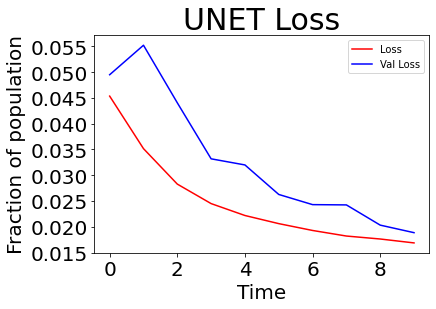

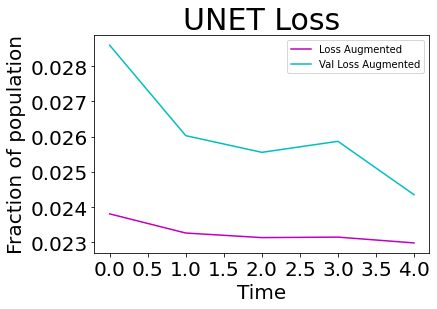

In [7]:
# Print results for training MSE and validation MSE
plt.plot(h_21.history['loss'], 'r', label='Loss')
plt.plot(h_21.history['val_loss'], 'b', label='Val Loss')
plt.title('UNET Loss', fontsize=30)
plt.xlabel("Time", fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Fraction of population", fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best')
plt.show()
plt.plot(h_22.history['loss'], 'm', label='Loss Augmented')
plt.plot(h_22.history['val_loss'], 'c', label='Val Loss Augmented')
plt.title('UNET Loss', fontsize=30)
plt.xlabel("Time", fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Fraction of population", fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='best')
plt.show()

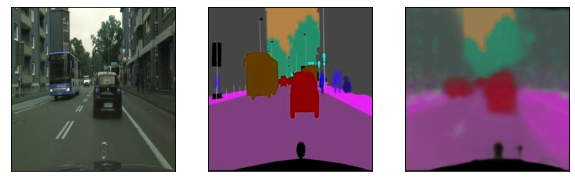

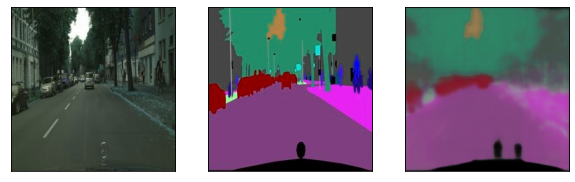

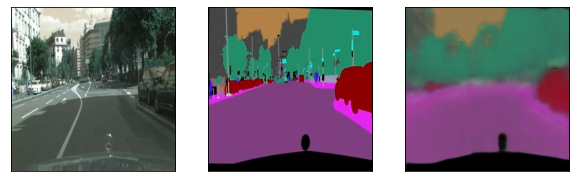

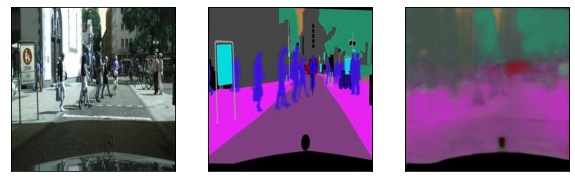

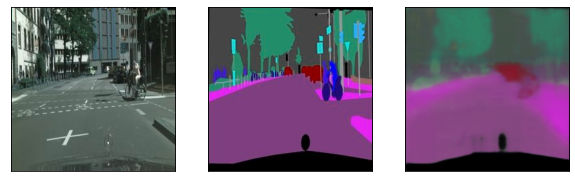

In [8]:
#show the result
pp2 = model2.predict(x_test[:5,:,:,:], batch_size=1)

ni = 5
for k in range(ni):
    plt.figure(figsize=(10,30))
    plt.subplot(ni,3,1+k*3)
    plt.imshow(x_test[k])
    figure = plt.gca()
    x_axis = figure.axes.get_xaxis()
    x_axis.set_visible(False)
    y_axis = figure.axes.get_yaxis()
    y_axis.set_visible(False)
    plt.subplot(ni,3,2+k*3)
    plt.imshow(y_test[k])
    figure = plt.gca()
    x_axis = figure.axes.get_xaxis()
    x_axis.set_visible(False)
    y_axis = figure.axes.get_yaxis()
    y_axis.set_visible(False)
    plt.subplot(ni,3,3+k*3)
    plt.imshow(pp2[k])
    figure = plt.gca()
    x_axis = figure.axes.get_xaxis()
    x_axis.set_visible(False)
    y_axis = figure.axes.get_yaxis()
    y_axis.set_visible(False)

In [9]:
intersection = np.logical_and(y_test[1,:,:,:], pp2)
union = np.logical_or(y_test[1,:,:,:], pp2)
iou_score = np.sum(intersection) / np.sum(union)
print(iou_score)

0.9607899983723959


In [10]:
diff2 = y_test[1] - pp2[1] 
m_norm2 = np.sum(abs(diff2))  
print(m_norm2)
print(m_norm2/(256*256))

13774.887988135903
0.21018811017053074
